In [1]:
#Necesario para trabajar con Google Drive, montamos el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Comprobamos que el GPU existe en google drive
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#install catboost en drive
pip install catboost

In [4]:
#Importamos los paquetes necesarios
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import pickle
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
#Definimos las funciones que utilizaremos
def metrics(x,y):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    acc = accuracy_score(x,y)
    f1 = f1_score(x,y,average=None)
    f1av = np.mean( f1_score(x,y,average=None))
    #MATRIZ DE CONFUSION
    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay.from_predictions(x, y)
    disp.ax_.set_title("Confusion Matrix from Predictions")
    return print(f'Accuracy score: {acc} \nF1 Score: {f1}\nMean F1: {f1av}'), plt.show()

def crossv(model, x, y):
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(model, x, y, scoring="f1_micro", cv=3, n_jobs=-1, verbose=2)
    mean_score = scores.mean()
    return print(f'F1 scores: {scores}\nF1 micro mean: {mean_score}')

In [56]:
#Importamos los csv necesarios para trabajar, en este caso aquellos creados con Embedding
pathtest2 = '/content/drive/MyDrive/Colab Notebooks/earthquake_test_emb_1.csv'
test_emb = pd.read_csv(pathtest2)
test_lc = test_emb.drop(columns=['Unnamed: 0'])


In [49]:
pathtrain2 = '/content/drive/MyDrive/Colab Notebooks/earthquake_Xtrain_emb.csv'
X_train_emb = pd.read_csv(pathtrain2)
X_train_lc = X_train_emb.drop(columns=['damage_grade','Unnamed: 0'])
y_train_lc = X_train_emb['damage_grade']

In [37]:
pathxtest = '/content/drive/MyDrive/Colab Notebooks/earthquake_Xtest_emb.csv'
X_test_emb = pd.read_csv(pathxtest)
X_test_lc = X_test_emb.drop(columns=['damage_grade','Unnamed: 0'])
y_test_lc = X_test_emb['damage_grade']

In [11]:
#Importamos los csv necesarios para trabajar, aquellos originales 
pathtest = '/content/drive/MyDrive/Colab Notebooks/Earthquake_test.csv'
test = pd.read_csv(pathtest)
test.drop(columns='building_id', inplace=True)

pathtrain = '/content/drive/MyDrive/Colab Notebooks/Earthquake_train.csv'
df = pd.read_csv(pathtrain)
df.drop(columns='building_id', inplace=True)
df

In [13]:
# Separamos el conjunto sin procesado en train en train y test
X = df.copy().drop('damage_grade', axis=1)
y = df['damage_grade']

In [14]:
#Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [15]:
#Creamos una lista de columnas o atributos
columnas = list(X_train.columns)

In [ ]:
#Implementamos Catboost con los valores finales
modelcb = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, iterations=1000,  
                            verbose=True,cat_features=columnas, eval_metric= 'TotalF1',
                            depth= 6,
                            learning_rate = 0.1
                            l2_leaf_reg= 3)
modelcb.fit(X_train, y_train)


In [ ]:
#Predecimos con el model
y_pred3 = modelcb.predict(X_test)

In [ ]:
#guardamos el modelo 
pickle.dump(modelcb, open('modelcatboost.pkl', 'wb'))

In [ ]:
#Si queremos volver a cargarlo
catboost1 = pickle.load(open('modelcatboost.pkl', 'rb'))
#pickled_model.predict(X_test)

In [ ]:
#Visualizamos la feature importance de este modelo
feat_importance = pd.DataFrame(modelcb.feature_importances_)
fimport = feat_importance.set_axis(X_train.columns, axis='index')
fimport.sort_values(by=[0], ascending= False, inplace = True)

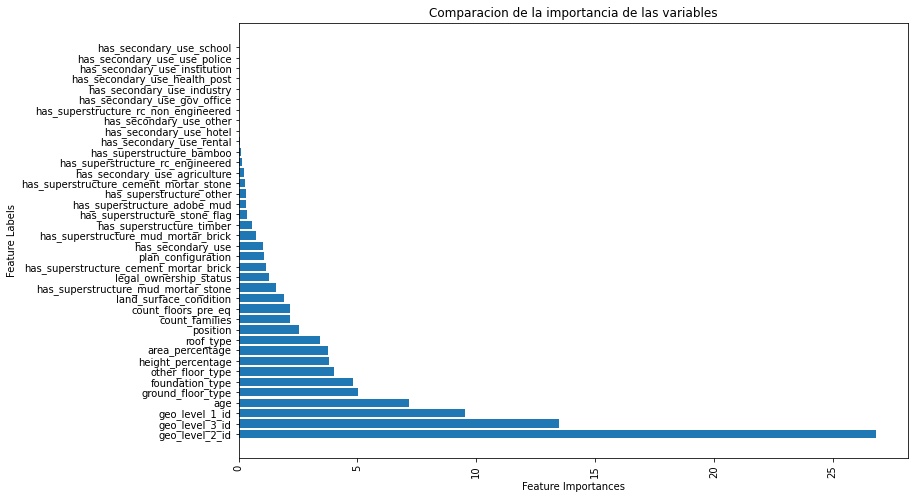

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.barh(fimport.index, fimport[0])
plt.xlabel('Feature Importances')
plt.xticks(rotation = 90)
plt.ylabel('Feature Labels')
plt.title('Comparacion de la importancia de las variables')
plt.show()

Accuracy score: 0.7486569455103607 
F1 Score: [0.60127772 0.79689623 0.69260002]
Mean F1: 0.6969246545527669


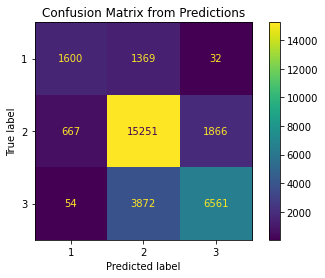

(None, None)

In [ ]:
#Visualizamos las metricas
metrics(y_test, y_pred3)

In [ ]:
#Hacemos validacion cruzada
crossv(modelcb, X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


F1 scores: [0.74069455 0.73942345 0.74182176]
F1 micro mean: 0.7406465848042978


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.4min finished


In [ ]:
#Preparamos el fichero para la submission
testindex = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Earthquake_test.csv')
testindex = pd.DataFrame(testindex['building_id'])
testindex


,building_id
0,360320
1,479622
2,541371
3,429841
4,373726
...,...
104236,308121
104237,444264
104238,545414
104239,130515


In [ ]:
predict_comp = modelcb.predict(test)
prediccion = pd.DataFrame(predict_comp)


In [ ]:
submission = pd.concat([testindex, prediccion,], axis=1)
submission

,building_id,0
0,360320,2
1,479622,2
2,541371,2
3,429841,2
4,373726,2
...,...,...
104236,308121,2
104237,444264,3
104238,545414,2
104239,130515,2


In [ ]:
submission.set_index('building_id', inplace=True)
submission.rename(columns={0:'damage_grade'}, inplace=True)
submission

,damage_grade
building_id,
360320,2
479622,2
541371,2
429841,2
373726,2
...,...
308121,2
444264,3
545414,2


In [ ]:
submission.to_csv('submission201222cb.csv')

# Embedding

In [39]:
columnas_lc = list(X_train_lc.columns)

In [59]:
#Catboost no admite float como columna, lo cual seguramente afectara significativamente el modelo y los pesos del embedding
# pero convertimos las columnas para observer como se comporta de todos modos
X_train_lc["g1_1"] = X_train_lc["g1_1"].astype(int) 
X_train_lc["g1_2"] = X_train_lc["g1_2"].astype(int) 
X_train_lc["g1_3"] = X_train_lc["g1_3"].astype(int) 
X_train_lc["g1_4"] = X_train_lc["g1_4"].astype(int) 
X_train_lc["g1_5"] = X_train_lc["g1_5"].astype(int) 
X_train_lc["g1_6"] = X_train_lc["g1_6"].astype(int) 
X_train_lc["g1_7"] = X_train_lc["g1_7"].astype(int) 
X_train_lc["g1_8"] = X_train_lc["g1_8"].astype(int) 
X_train_lc["g1_9"] = X_train_lc["g1_9"].astype(int) 
X_train_lc["g1_10"] = X_train_lc["g1_10"].astype(int) 
X_train_lc["g1_11"] = X_train_lc["g1_11"].astype(int) 
X_train_lc["g1_12"] = X_train_lc["g1_12"].astype(int) 
X_train_lc["g1_13"] = X_train_lc["g1_13"].astype(int) 
X_train_lc["g1_14"] = X_train_lc["g1_14"].astype(int) 
X_train_lc["g1_15"] = X_train_lc["g1_15"].astype(int) 
X_train_lc["g1_16"] = X_train_lc["g1_16"].astype(int) 

In [60]:
X_test_lc["g1_1"] = X_test_lc["g1_1"].astype(int) 
X_test_lc["g1_2"] = X_test_lc["g1_2"].astype(int)
X_test_lc["g1_3"] = X_test_lc["g1_3"].astype(int) 
X_test_lc["g1_4"] = X_test_lc["g1_4"].astype(int) 
X_test_lc["g1_5"] = X_test_lc["g1_5"].astype(int) 
X_test_lc["g1_6"] = X_test_lc["g1_6"].astype(int) 
X_test_lc["g1_7"] = X_test_lc["g1_7"].astype(int) 
X_test_lc["g1_8"] = X_test_lc["g1_8"].astype(int) 
X_test_lc["g1_9"] = X_test_lc["g1_9"].astype(int) 
X_test_lc["g1_10"] = X_test_lc["g1_10"].astype(int) 
X_test_lc["g1_11"] = X_test_lc["g1_11"].astype(int) 
X_test_lc["g1_12"] = X_test_lc["g1_12"].astype(int)  
X_test_lc["g1_13"] = X_test_lc["g1_13"].astype(int) 
X_test_lc["g1_14"] = X_test_lc["g1_14"].astype(int) 
X_test_lc["g1_15"] = X_test_lc["g1_15"].astype(int) 
X_test_lc["g1_16"] = X_test_lc["g1_16"].astype(int) 

In [61]:
test_lc["g1_1"] = test_lc["g1_1"].astype(int) 
test_lc["g1_2"] = test_lc["g1_2"].astype(int)
test_lc["g1_3"] = test_lc["g1_3"].astype(int) 
test_lc["g1_4"] = test_lc["g1_4"].astype(int) 
test_lc["g1_5"] = test_lc["g1_5"].astype(int) 
test_lc["g1_6"] = test_lc["g1_6"].astype(int) 
test_lc["g1_7"] = test_lc["g1_7"].astype(int) 
test_lc["g1_8"] = test_lc["g1_8"].astype(int) 
test_lc["g1_9"] = test_lc["g1_9"].astype(int) 
test_lc["g1_10"] = test_lc["g1_10"].astype(int) 
test_lc["g1_11"] = test_lc["g1_11"].astype(int) 
test_lc["g1_12"] = test_lc["g1_12"].astype(int)  
test_lc["g1_13"] = test_lc["g1_13"].astype(int) 
test_lc["g1_14"] = test_lc["g1_14"].astype(int) 
test_lc["g1_15"] = test_lc["g1_15"].astype(int) 
test_lc["g1_16"] = test_lc["g1_16"].astype(int) 

In [62]:
#Probamos con la reduccion de variables


from catboost import CatBoostClassifier
modelcb2 = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, verbose=True,cat_features=columnas_lc)
modelcb2.fit(X_train_lc, y_train_lc)


Learning rate set to 0.101223
0:	learn: 0.6618716	total: 235ms	remaining: 3m 55s
1:	learn: 0.6730147	total: 428ms	remaining: 3m 33s
2:	learn: 0.6698003	total: 578ms	remaining: 3m 12s
3:	learn: 0.6728782	total: 724ms	remaining: 3m
4:	learn: 0.6744971	total: 889ms	remaining: 2m 56s
5:	learn: 0.6745392	total: 1.03s	remaining: 2m 51s
6:	learn: 0.6813087	total: 1.2s	remaining: 2m 49s
7:	learn: 0.6825060	total: 1.36s	remaining: 2m 48s
8:	learn: 0.6835599	total: 1.5s	remaining: 2m 45s
9:	learn: 0.6844147	total: 1.66s	remaining: 2m 44s
10:	learn: 0.6848476	total: 1.83s	remaining: 2m 45s
11:	learn: 0.6852337	total: 1.99s	remaining: 2m 43s
12:	learn: 0.6892096	total: 2.16s	remaining: 2m 43s
13:	learn: 0.6922034	total: 2.3s	remaining: 2m 42s
14:	learn: 0.6953476	total: 2.5s	remaining: 2m 44s
15:	learn: 0.6971770	total: 2.68s	remaining: 2m 45s
16:	learn: 0.6976390	total: 2.9s	remaining: 2m 47s
17:	learn: 0.6981237	total: 3.08s	remaining: 2m 47s
18:	learn: 0.6999279	total: 3.27s	remaining: 2m 48s
1

In [64]:
#predecimos
ypredem = modelcb2.predict(X_test_lc)

In [ ]:
#visualizamos las metricas
metrics(y_test, ypredem)